# <center> Simulating the Prisonner's Dilemma and Understanding Cooperation Rates </center>

The following simulation was one of my assignments for Quantitative Economics with Python. The Prisoner's Dilemma is a situation in game theory where two individuals can either cooperate or betray each other, with the optimal outcome being mutual cooperation. However, rational self-interest often leads both to betray, resulting in a worse outcome for both. The simulation aims to understand human decision-making and learning as players engage in multiple matches and adjust their strategies based on the payoffs they receive. **The details are as follows:**

Start with a population of $N=30$ players. Players are randomly paired for each match. Each match will last $T=20$ rounds. After each match players are randomly re-matched. Do this for $M = 100$ matches. 

At the begininning of each match $m$, the simulation takes the following steps:
- 1. Each player $i$ follows the  probabilistic choice rule to choose one of the five strategies to play. The probability of choosing a strategy $s_{i,k}$ is: 

       $$ \frac{e^{\lambda v_{i,k}(m)}}{\sum e^{\lambda v_{i,j}(m)} } $$
    
where $v_{i,k}(m)$ is the value associated with playing strategy $k$, $e^{\lambda v_{i,j}(m)}$ is $e$ to the power of $\lambda \times v_{i,j}(m)$, and $\sum e^{\lambda v_{i,j}(m)}$ is the sum over all player $i$'s strategies.

Assume at match 1, the probability of choosing each strategy is equal to 20%.

- 2. Once the strategies are chosen, the players will decide their actions for each round of the total $T=20$ rounds.They will then know their total payoffs for match *m*. 

The strategies are as follows (and the functions are given below.) 
    - **ALLD**: the player will always choose D.
    - **ALLC**: the player will always choose C.
    - **TFT**: the player starts with C and replicates his/her opponent's action in the previous round.
    - **GRIM**: the player starts with C and will continue C as long as the opponent chooses C; however, if the opponent chose D in the previous round, the player will choose D and never switch back to C.
    - **DTFT**: similar to TFT, the difference is that the player will start with D. 
    
- 3. Once the payoff of playing strategy $k$ ($P_{i,k}(m)$) is determined, the value of strategy $k$ for match $m+1$ will be updated following this equation: 

$$ v_{i,k}(m+1) = (1-\alpha) v_{i,k}(m) + \alpha P_{i,k}(m)$$

Assume that the weight given to the realized payoff is **$\alpha = 0.2$**. 

As mentioned above, the input will be a payoff matrix that presents payoffs of the row player:
\begin{array}{ccc} 
 & C & D \\
C & 32 & 12\\ 
D & 50 & 25
\end{array}

### <center> Model Description </center>

In [34]:
import os
import shutil as sh
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import numpy as np

In [27]:

class Player():
    def __init__(self, lam, strategies):
        # Initialize player with a strategy, values, and opponent's last move
        self.strategy = None
        self.values = np.ones(len(strategies)) * 31
        self.last_opponent_move = None
        self.defected = False
        self.lam = lam  
        
    def choose_strategy(self):
        # Calculate the probabilities of choosing each strategy based on expected values
        # Select a strategy according to these probabilities
        exp_values = np.exp(self.lam*self.values)
        probabilities = exp_values / np.sum(exp_values)
        self.strategy = np.random.choice(range(len(probabilities)), p=probabilities)
        
    def reset(self):
        # Reset the player's defect status and last opponent move for a new match
        self.defected = False
        self.last_opponent_move = None 
        
    def play_first_round(self):
        # Return the player's move for the first round based on their strategy
        # Each strategy is represented by a specific return value (0 or 1)
        if self.strategy == 0:  # ALLD
            return 0
        elif self.strategy == 1:  # ALLC
            return 1
        elif self.strategy == 2:  # TFT
            return 1
        elif self.strategy == 3:  # GRIM
            return 1
        elif self.strategy == 4:  # DTFT
            return 0

    def play(self):
        # Return the player's move for subsequent rounds based on their strategy
        # Strategies adapt based on the last opponent's move for certain strategies
        if self.strategy == 0:  # ALLD
            return 0
        elif self.strategy == 1:  # ALLC
            return 1
        elif self.strategy == 2:  # TFT
            return self.last_opponent_move  if self.last_opponent_move  is not None else 1  # Cooperate or defect based on opponent's last move
        elif self.strategy == 3: # GRIM
            if self.defected:
                return 0 
            if self.last_opponent_move  == 0:
                self.defected = True
                return 0
            return 1   # Cooperate if opponent cooperated last time
        elif self.strategy == 4:  # DTFT
            if self.last_opponent_move is None or self.last_opponent_move == 1:
                return 1
            else:
                return 0

def prisoner_dilemma( matrix = np.array([[32,12],[50,25]]),N = 30, M = 100, T = 20, alpha = .2, lam = 1,strategies = ["ALLD", "ALLC", "TFT", "GRIM", "DTFT"] ):
    # Initialize players and record simulation metrics
    # Create players and track strategy counts and payoffs
    plt.ioff()
    players = []
    # These ariables  record metrics important in understanding the results
    strategy_counts = [0] * len(strategies)
    strategy_payoffs = [0]*len(strategies)
    cumulative_counts = np.zeros((M, len(strategies))) 
    for i in range(N):
        players.append(Player(lam, strategies))
    results = np.zeros(M)
    for match in range(M):
        # Shuffle players to randomize pairings for each match
        # Reset players and have them choose their strategies
        np.random.shuffle(players)
        for player in players:
            # Reset defect status and last opponent's move to prepare for a new match
            player.reset()
            player.choose_strategy()
            strategy_counts[player.strategy] += 1
        cumulative_counts[match] = strategy_counts.copy() 
        total_cooperation = 0
        for i in range(0,N,2):
            player1, player2 = players[i],players[i+1]
            r1, r2 = 0,0
            for rd in range(T):
                if rd == 0:
                    # Determine the player's move for the first round based on their selected strategy
                    move1 = player1.play_first_round()
                    move2 = player2.play_first_round()
                else:
                    move1 = player1.play()
                    move2 = player2.play()
                    # Update last opponent move for each player
                player1.last_opponent_move = move2
                player2.last_opponent_move = move1
                # Update the players' payoff based on the outcome of their moves
                if move1 == 1 and move2 == 1:  # Both cooperate
                    r1 += matrix[0][0]  # Player 1's payoff
                    r2 += matrix[0][0]  # Player 2's payoff
                    total_cooperation += 2
                elif move1 == 1 and move2 == 0:  # Player 1 cooperates, Player 2 defects
                    r1 += matrix[0][1]  # Player 1's payoff
                    r2 += matrix[1][0]  # Player 2's payoff
                elif move1 == 0 and move2 == 1:  # Player 1 defects, Player 2 cooperates
                    r1 += matrix[1][0]  # Player 1's payoff
                    r2 += matrix[0][1]  # Player 2's payoff
                else:  # Both defect
                    r1 += matrix[1][1]  # Player 1's payoff
                    r2 += matrix[1][1]  # Player 2's payoff
                    
            # Update the players' learning and decision probabilities
            strategy_payoffs[player1.strategy] += r1/T
            strategy_payoffs[player2.strategy] += r2/T
            player1.values[player1.strategy] = (1 - alpha) * player1.values[player1.strategy] + (alpha * r1 / T )
            player2.values[player2.strategy] = (1 - alpha) * player2.values[player2.strategy] + (alpha * r2/ T )
        # Recording the average cooperation for the match    
        results[match] = total_cooperation / (T*N)
        
    # Plot the average cooperation rate across all matches - f1
    # Visualize the number of times each strategy was chosen - f2
    # Plot the average payoff per strategy - f3
    # Show cumulative strategy counts over matches - f4
    f1 = plt.figure()
    plt.plot(results, color = 'purple')
    plt.xlabel('Match Number')
    plt.ylabel('Cooperation Rate')
    plt.title(f'Average Cooperation Rate Over {M} Matches.')
    plt.grid()
    #plt.show()

    f2 = plt.figure()
    barplot = plt.bar(strategies, strategy_counts, color = 'purple')
    plt.bar_label(barplot)
    plt.title(f"Frequency of Strategy Usage Across {M} Matches.")
    plt.xlabel('Strategy')
    plt.ylabel('Counts')
    plt.grid()
    #plt.show()

    average_payoffs = [0]*len(strategies)
    for i in range(len(strategies)):
        average_payoffs[i] = int(round(strategy_payoffs[i] / strategy_counts[i], 0))  

    f3 = plt.figure()
    barplot = plt.bar(strategies, average_payoffs, color = 'purple')
    plt.bar_label(barplot)
    plt.title(f'Average Payoff Per Match, Across {M} Matches')
    plt.xlabel('Strategy')
    plt.ylabel('Average Payoff')
    plt.grid()
    #plt.show()

    f4 = plt.figure()
    for i in range(len(strategies)):
        plt.plot(range(M), cumulative_counts[:,i],label = strategies[i])
    
    plt.xlabel('Match Number')
    plt.ylabel('Cumulative Strategy Counts')
    plt.title(f"Total Strategy Usage Over {M} Matches.")
    plt.legend()
    plt.grid()
    #plt.show()
    
    return f1, f2, f3, f4
 
            
plt1, plt2, plt3, plt4 = prisoner_dilemma()





### <center> Visualizing the Results</center>

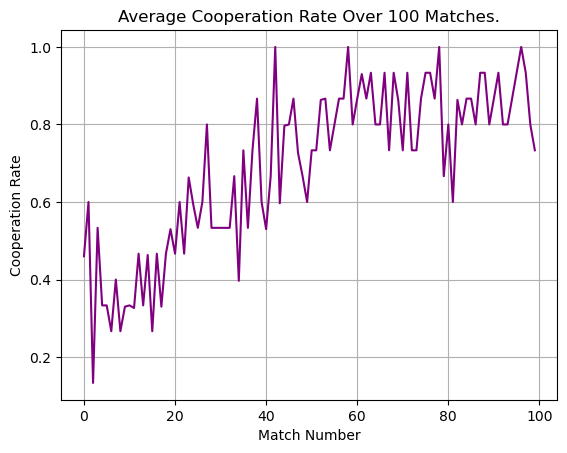

In [33]:
plt.figure(plt1)
plt.show() 
plt.close(plt1)

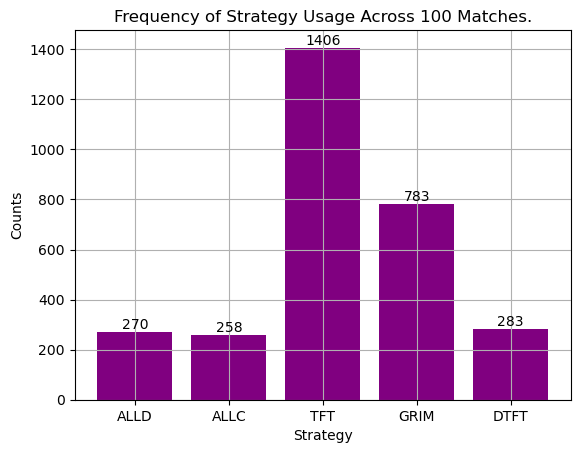

In [32]:
plt.figure(plt2)
plt.show() 
plt.close(plt2)

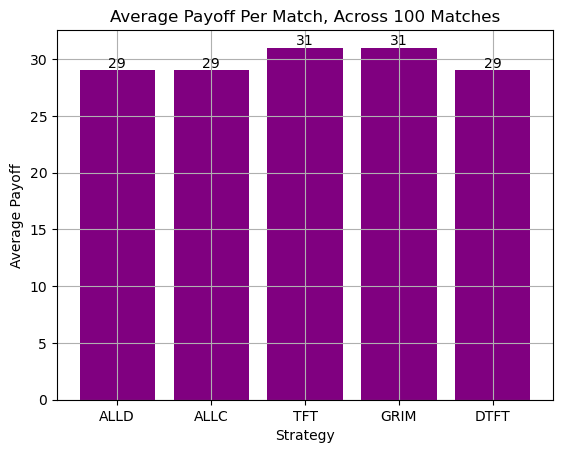

In [31]:
plt.figure(plt3)
plt.show() 
plt.close(plt3)

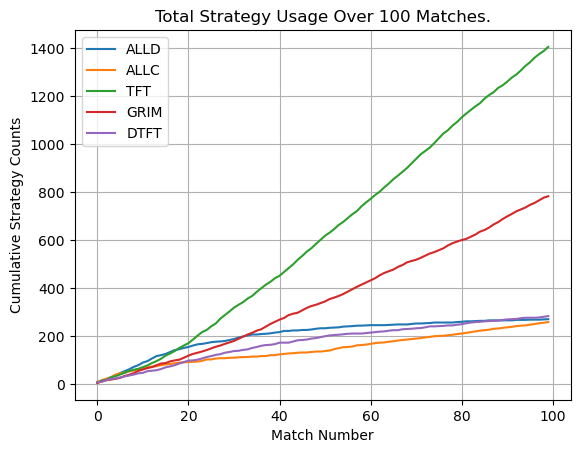

In [30]:
plt.figure(plt4)
plt.show() 
plt.close(plt4)

### <center> Summary</center>
At the beginning of the simulation, players exhibited a tendency to cooperate roughly 50% of the time. However, this cooperation rate gradually declined, experiencing significant drops below 40%. Interestingly, around matches 35 to 40, cooperation rates began to rebound, ultimately stabilizing above 60%, with some matches even reaching 100% cooperation.

Analyzing the data reveals that the strategies “Tit for Tat” (TFT) and “Grim” emerged as the most frequently used, as shown in Visual #2, and these strategies also yielded higher average payoffs per match, according to Visual #3. Notably, players began to "learn" from their experiences, as evidenced in Visual #4, with a marked increase in the adoption of TFT and Grim strategies around round 20. Ultimately, the cumulative totals for the rest of the strategies plateaued after round 40.